In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.metrics import f1_score,accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kangj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#read dataset and allocated columns names
data = pd.read_csv("booksummaries.txt", sep='\t', names=["Wiki_id", "Freebase ID", "Book Title", "Author", "Publication Date", "Book Genres", "Plot Summary"])

In [3]:
#inspecting data 
data.head(10)

,Wiki_id,Freebase ID,Book Title,Author,Publication Date,Book Genres,Plot Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
5,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
6,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,2950,/m/012dq,Anyone Can Whistle,Arthur Laurents,NaN,NaN,The story is set in an imaginary American tow...
8,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."
9,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Beginning several months after the events in ...


In [4]:
#Drop unused columns
data.drop(['Freebase ID', 'Author', 'Publication Date'], axis=1, inplace=True)

In [5]:
data.head()

,Wiki_id,Book Title,Book Genres,Plot Summary
0,620,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,An Enquiry Concerning Human Understanding,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,A Fire Upon the Deep,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Wiki_id       16559 non-null  int64 
 1   Book Title    16559 non-null  object
 2   Book Genres   12841 non-null  object
 3   Plot Summary  16559 non-null  object
dtypes: int64(1), object(3)
memory usage: 517.6+ KB


In [7]:
data.shape

(16559, 4)

In [8]:
#Check for missing values
data.isnull().sum()

Wiki_id            0
Book Title         0
Book Genres     3718
Plot Summary       0
dtype: int64

In [9]:
#remove entries with missing values under Genres column.
data = data.dropna()

In [10]:
#recheck for missing values
data.isnull().sum()

Wiki_id         0
Book Title      0
Book Genres     0
Plot Summary    0
dtype: int64

In [11]:
#check the total number of genres (including duplicates)
print(len(data['Book Genres']))

12841


In [12]:
#Convert String into list and extract only genres category
Genre = []

for i in data['Book Genres']:
    Genre.append(list(json.loads(i).values()))

data['Genres'] = Genre
data.drop("Book Genres", axis = 1, inplace = True)

In [13]:
data.head(10)

,Wiki_id,Book Title,Plot Summary,Genres
0,620,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...","[Roman à clef, Satire, Children's literature, ..."
1,843,A Clockwork Orange,"Alex, a teenager living in near-future Englan...","[Science Fiction, Novella, Speculative fiction..."
2,986,The Plague,The text of The Plague is divided into five p...,"[Existentialism, Fiction, Absurdist fiction, N..."
4,2080,A Fire Upon the Deep,The novel posits that space around the Milky ...,"[Hard science fiction, Science Fiction, Specul..."
5,2152,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...","[War novel, Roman à clef]"
6,2890,A Wizard of Earthsea,"Ged is a young boy on Gont, one of the larger...","[Children's literature, Fantasy, Speculative f..."
8,4081,Blade Runner 3: Replicant Night,"Living on Mars, Deckard is acting as a consul...","[Science Fiction, Speculative fiction]"
9,4082,Blade Runner 2: The Edge of Human,Beginning several months after the events in ...,"[Science Fiction, Speculative fiction]"
15,4386,Book of Job,The book of Job tells the story of an extreme...,[Religious text]
20,6020,Crash,The story is told through the eyes of narrato...,"[Speculative fiction, Fiction, Novel]"


In [14]:
#convert genre into a single list
list_genre = [item for elem in Genre for item in elem]

In [15]:
#total number of different unique genre listed in the dataset
len(set(list_genre))

227

In [16]:
#create dictonary and store the counts and the respective type of genre
genre_count = dict(Counter(list_genre))

values = list(genre_count.values())
labels = list(genre_count.keys())

genre_count_df = pd.DataFrame({'Genre': labels, 'Count': values})

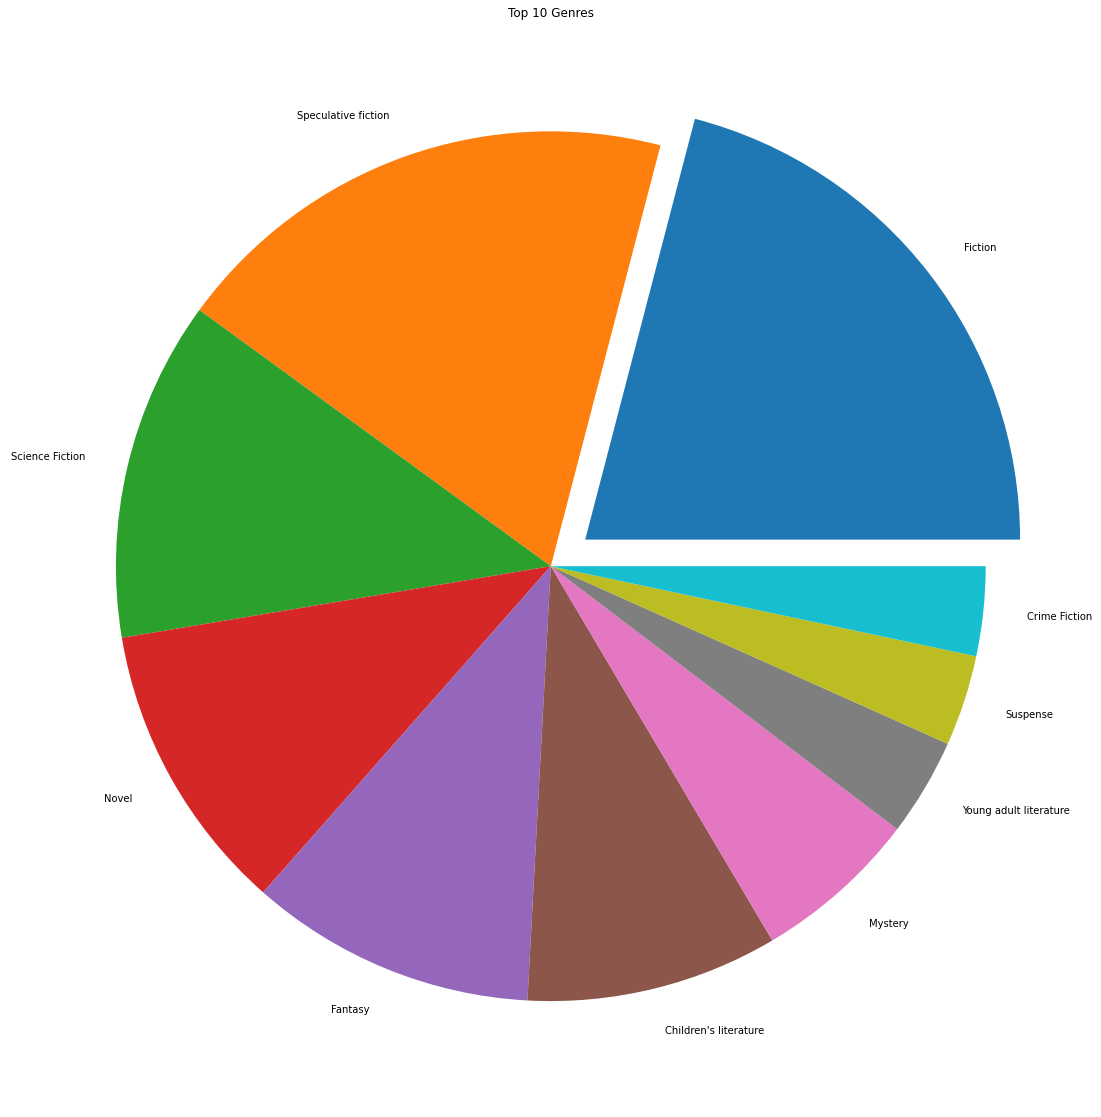

In [17]:
#Generate piechart with the top 10 genre in terms of counts
n = genre_count_df.nlargest(columns = 'Count', n = 10)

explode = (0.1, 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0)

fig = plt.figure(figsize=(50,20))
plt.pie(n['Count'], labels= n['Genre'], explode = explode)
plt.title("Top 10 Genres")
plt.show()

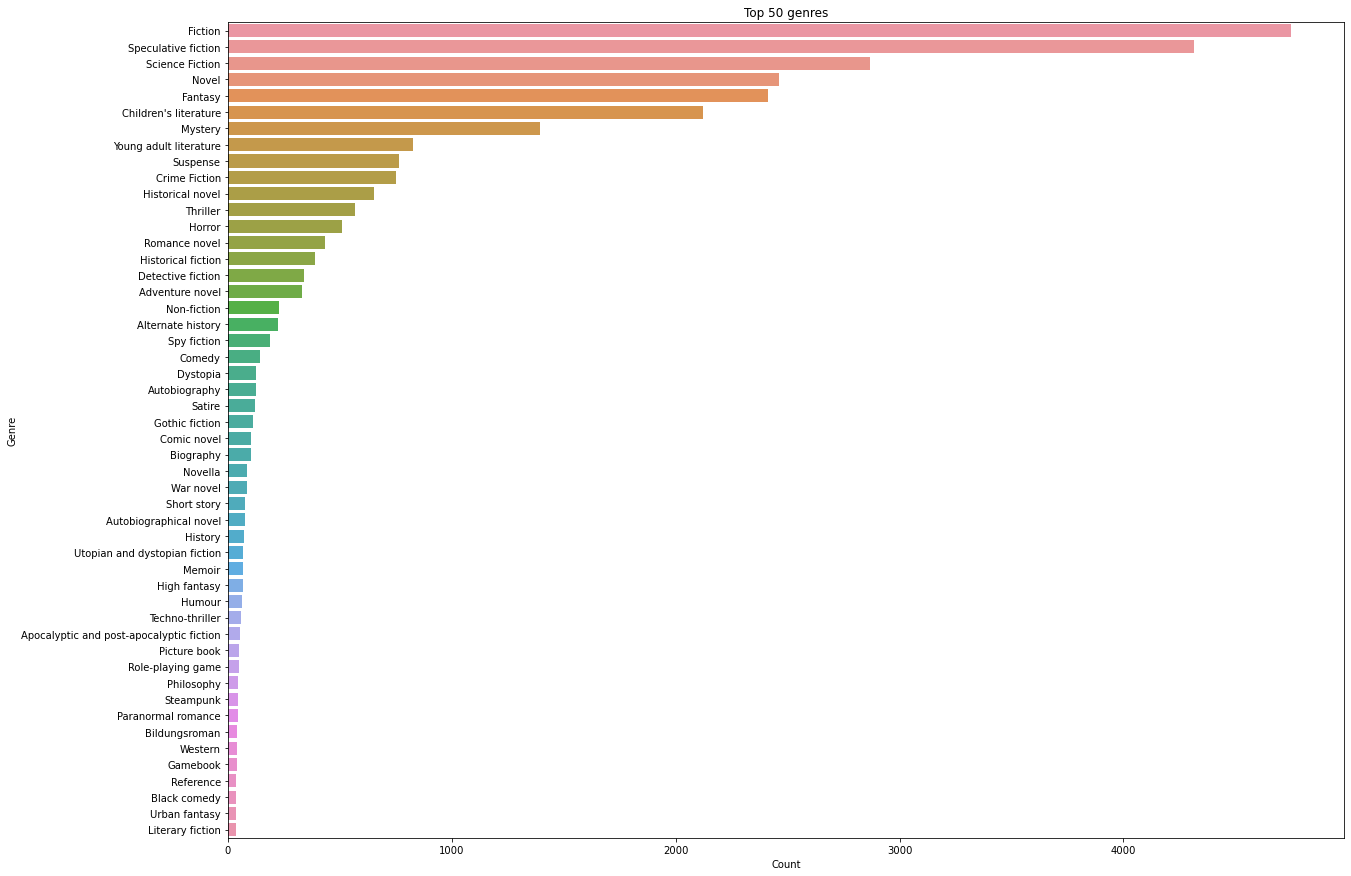

In [18]:
#generate barplot of top 50 genres in terms of counts
b = genre_count_df.nlargest(columns = 'Count', n = 50)

plt.figure(figsize = (20,15))
ax = sns.barplot(data = b , x = "Count", y = "Genre")
ax.set(ylabel = "Genre", xlabel = 'Count')
plt.title("Top 50 genres")
plt.show()

In [19]:
# Data Pre-processing 

def cleaning_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = "".join([char for char in text if char not in string.punctuation])
    
    tokens = word_tokenize(text)
    tokens = [w for w in text.split() if w not in stopwords.words('english')]
    
    text = ' '.join(tokens)
    
    return text


In [20]:
#apply pre processing function into plot summary column
data['Plot Summary'] = data['Plot Summary'].apply(lambda x : cleaning_text(x))

In [21]:
data.head(10)

,Wiki_id,Book Title,Plot Summary,Genres
0,620,Animal Farm,old major old boar manor farm calls animals fa...,"[Roman à clef, Satire, Children's literature, ..."
1,843,A Clockwork Orange,alex teenager living near future england leads...,"[Science Fiction, Novella, Speculative fiction..."
2,986,The Plague,text plague divided five parts town oran thous...,"[Existentialism, Fiction, Absurdist fiction, N..."
4,2080,A Fire Upon the Deep,novel posits space around milky way divided co...,"[Hard science fiction, Science Fiction, Specul..."
5,2152,All Quiet on the Western Front,book tells story paul b umer german soldier ur...,"[War novel, Roman à clef]"
6,2890,A Wizard of Earthsea,ged young boy gont one larger islands north ar...,"[Children's literature, Fantasy, Speculative f..."
8,4081,Blade Runner 3: Replicant Night,living mars deckard acting consultant movie cr...,"[Science Fiction, Speculative fiction]"
9,4082,Blade Runner 2: The Edge of Human,beginning several months events blade runner d...,"[Science Fiction, Speculative fiction]"
15,4386,Book of Job,book job tells story extremely righteous man n...,[Religious text]
20,6020,Crash,story told eyes narrator james ballard named a...,"[Speculative fiction, Fiction, Novel]"


In [22]:
#encode genre column into one-hot vector  
x = data['Plot Summary']

lb = MultiLabelBinarizer()
y = lb.fit_transform(data['Genres'])

In [23]:
#Data Split into 80%/20% 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)   

In [24]:
#Extract and create features
tfidf_vectorizer = TfidfVectorizer(max_features=10000, max_df=0.80) 

tfidf_vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.8, max_features=10000)

In [25]:
Xtrain_tfidf = tfidf_vectorizer.transform(X_train)
Xtest_tfidf = tfidf_vectorizer.transform(X_test)

In [26]:
#setup gridsearch cv parameters
parameters = {'k': [20,25,30], 's': [0.5,1.0]}
score = 'f1_micro'

In [27]:
#fit model with gridsearchcv
clf = GridSearchCV(MLkNN(), parameters, scoring=score)

clf.fit(Xtrain_tfidf, y_train)

C:\Users\kangj\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\kangj\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\kangj\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\kangj\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=20 as keyword args. From version 0.25 passing these as positional arguments will resul

GridSearchCV(estimator=MLkNN(), param_grid={'k': [20, 25, 30], 's': [0.5, 1.0]},
             scoring='f1_micro')

In [28]:
print(clf.best_params_)

{'k': 25, 's': 0.5}


In [33]:
#implement Multilabel KNN model
knn = MLkNN(k = 25, s = 0.5)

knn.fit(Xtrain_tfidf, y_train)


C:\Users\kangj\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=25 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


MLkNN(k=25, s=0.5)

In [34]:
pred_y = knn.predict(Xtest_tfidf)

In [50]:
f1_score(y_test,pred_y, average = "micro")

0.42204621894325706

In [48]:
accuracy_score(y_test,pred_y)

0.12183729077462048

# Conclusion

The model produce an accuracy score of 0.12 which is relatively low. This could be explained as the accuracy_score metric from sklearn library only caputures fully correct result. However, in a multilabel classification problem results can be identified as partial correct or fully correct. This can be correctly evaluated using the f1-score which calculates the average precision and recall score. It produce a score of 0.422. 